<a href="https://colab.research.google.com/github/jacobdwatters/NIOSH-Project/blob/main/BreakpointClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from numpy.random import seed
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score, roc_auc_score, mean_absolute_error, mean_squared_error, recall_score, f1_score, precision_score
from numpy.linalg import lstsq

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

import scipy as sp
from scipy import stats

import joblib

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
path_after_2010 = '/content/gdrive/My Drive/School/Grad School/NIOSH Project/Data/violations_processed_after_2010.csv'
violation_data = pd.read_csv(path_after_2010)

<ipython-input-5-837e5d150e00>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  violation_data = pd.read_csv(path_after_2010)


In [25]:
FEATURES = ['YEAR_OCCUR', 'VIOLATOR_VIOLATION_CNT',
'VIOLATOR_INSPECTION_DAY_CNT', 'MINE_TYPE',
'PRIMARY_OR_MILL', 'COAL_METAL_IND', 'VIOLATOR_TYPE_CD', 'NO_AFFECTED', 'SIG_SUB', 'NEGLIGENCE', 'INJ_ILLNESS']
TARGETS = ['PROPOSED_PENALTY']

X = violation_data[FEATURES]
y = violation_data[TARGETS]

In [27]:
# Define which columns should be encoded vs scaled
columns_to_encode = ['MINE_TYPE', 'COAL_METAL_IND', 'PRIMARY_OR_MILL', 'VIOLATOR_TYPE_CD', 'SIG_SUB', 'NEGLIGENCE', 'INJ_ILLNESS']
columns_to_scale  = ['VIOLATOR_VIOLATION_CNT', 'VIOLATOR_INSPECTION_DAY_CNT', 'YEAR_OCCUR', 'NO_AFFECTED']

# Instantiate encoder/scaler
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False)

y = np.array(y)

# Scale and Encode Separate Columns
scaled_columns  = scaler.fit_transform(X[columns_to_scale])
encoded_columns = ohe.fit_transform(X[columns_to_encode])

# Concatenate (Column-Bind) Processed Columns Back Together
X_pre = np.concatenate([scaled_columns, encoded_columns], axis=1)
np.nan_to_num(X_pre, copy=False)

print('Features shape:', X_pre.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Features shape: (1530011, 25)


In [28]:
n_bins = 1000
hist_freq, hist_ends = np.histogram(y.T[0], bins=n_bins)
# get midpoints
hist_x = (hist_ends[:n_bins] + hist_ends[1:]) / 2
len(hist_x), len(hist_freq)

(1000, 1000)

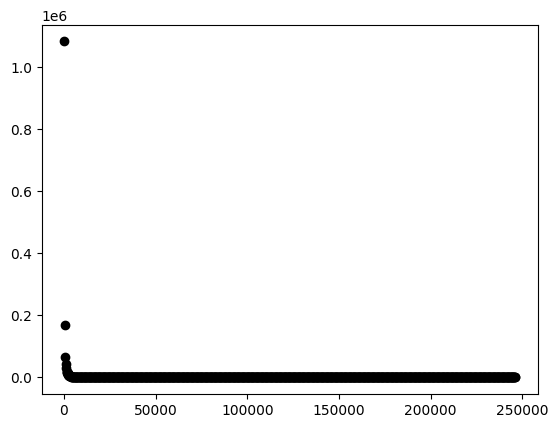

In [29]:
plt.plot(hist_x, hist_freq, 'ok')

In [30]:
# source: https://datascience.stackexchange.com/a/32833

ramp = lambda u: np.maximum( u, 0 )
step = lambda u: ( u > 0 ).astype(float)

def SegmentedLinearReg( X, Y, breakpoints ):
    nIterationMax = 10

    breakpoints = np.sort( np.array(breakpoints) )

    dt = np.min( np.diff(X) )
    ones = np.ones_like(X)

    for i in range( nIterationMax ):
        # Linear regression:  solve A*p = Y
        Rk = [ramp( X - xk ) for xk in breakpoints ]
        Sk = [step( X - xk ) for xk in breakpoints ]
        A = np.array([ ones, X ] + Rk + Sk )
        p =  lstsq(A.transpose(), Y, rcond=None)[0]

        # Parameters identification:
        a, b = p[0:2]
        ck = p[ 2:2+len(breakpoints) ]
        dk = p[ 2+len(breakpoints): ]

        # Estimation of the next break-points:
        newBreakpoints = breakpoints - dk/ck

        # Stop condition
        if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
            break

        breakpoints = newBreakpoints
    else:
        print( 'maximum iteration reached' )

    # Compute the final segmented fit:
    Xsolution = np.insert( np.append( breakpoints, max(X) ), 0, min(X) )
    ones =  np.ones_like(Xsolution)
    Rk = [ c*ramp( Xsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

    Ysolution = a*ones + b*Xsolution + np.sum( Rk, axis=0 )

    return Xsolution, Ysolution, breakpoints


Breakpoints: [514.50102434]


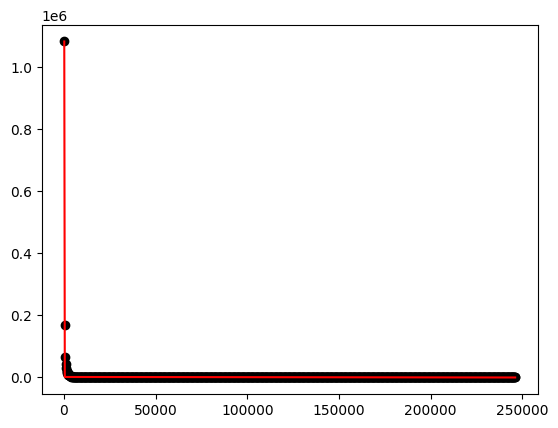

In [31]:
initialBreakpoints = [700]
plt.plot(hist_x, hist_freq, 'ok')
x_seg, y_seg, breakpoints = SegmentedLinearReg( hist_x, hist_freq, initialBreakpoints )
plt.plot(x_seg, y_seg, '-r' );
print(f'Breakpoints: {breakpoints}')

In [32]:
y_categories = y > breakpoints[0]
pd.Series(y_categories.T[0]).value_counts()

False    1180904
True      349107
dtype: int64

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_pre, y_categories, test_size = 0.25, random_state = 0)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_train shape:', y_test.shape)

X_train shape: (1147508, 25)
X_test shape: (382503, 25)
y_train shape: (1147508, 1)
y_train shape: (382503, 1)


In [34]:
batch_size = 2**14
epochs = 120

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model_breakpoint = keras.Sequential()

model_breakpoint.add(keras.Input(shape = (len(X_train[0]), ) ))
model_breakpoint.add(layers.Dense(64, activation="relu"))
model_breakpoint.add(layers.Dense(32, activation="relu"))
model_breakpoint.add(layers.Dense(16, activation="relu"))
model_breakpoint.add(layers.Dense(8, activation="relu"))
model_breakpoint.add(layers.Dense(8, activation="relu"))
model_breakpoint.add(layers.Dense(8, activation="relu"))
model_breakpoint.add(layers.Dense(1, activation="sigmoid"))


opt = keras.optimizers.Adam(learning_rate=0.01)
model_breakpoint.compile(loss="binary_crossentropy", optimizer=opt)
history = model_breakpoint.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/120
71/71 [==============================] - 3s 27ms/step - loss: 0.3354 - val_loss: 0.2365
Epoch 2/120
71/71 [==============================] - 2s 28ms/step - loss: 0.2296 - val_loss: 0.2263
Epoch 3/120
71/71 [==============================] - 3s 36ms/step - loss: 0.2091 - val_loss: 0.2015
Epoch 4/120
71/71 [==============================] - 2s 26ms/step - loss: 0.2111 - val_loss: 0.2137
Epoch 5/120
71/71 [==============================] - 2s 24ms/step - loss: 0.1993 - val_loss: 0.2019
Epoch 6/120
71/71 [==============================] - 2s 22ms/step - loss: 0.1898 - val_loss: 0.1907
Epoch 7/120
71/71 [==============================] - 2s 22ms/step - loss: 0.1881 - val_loss: 0.1893
Epoch 8/120
71/71 [==============================] - 2s 22ms/step - loss: 0.1851 - val_loss: 0.2120
Epoch 9/120
71/71 [==============================] - 2s 22ms/step - loss: 0.1958 - val_loss: 0.1864
Epoch 10/120
71/71 [==============================] - 2s 33ms/step - loss: 0.1850 - val_loss: 0.1879

In [35]:
y_pred = model_breakpoint.predict(X_test)
print(tf.metrics.binary_accuracy(y_test, y_pred))

11954/11954 [==============================] - 20s 2ms/step
tf.Tensor([1. 1. 1. ... 1. 1. 1.], shape=(382503,), dtype=float32)


In [36]:
bin_acc = tf.metrics.binary_accuracy(y_test, y_pred)
print(np.sum(bin_acc) / len(bin_acc))

0.9301103520756699


In [37]:
X_lower = X_pre[(y < breakpoints[0])[:, 0]]
y_lower = y[y < breakpoints[0]]
X_upper = X_pre[(y >= breakpoints[0])[:, 0]]
y_upper = y[y >= breakpoints[0]]

X_train_lower, X_test_lower, y_train_lower, y_test_lower = train_test_split(X_lower, y_lower, test_size = 0.25, random_state = 0)
X_train_upper, X_test_upper, y_train_upper, y_test_upper = train_test_split(X_upper, y_upper, test_size = 0.25, random_state = 0)

print('X_train_lower shape:', X_train_lower.shape)
print('X_test_lower shape:', X_test_lower.shape)
print('y_train_lower shape:', y_train_lower.shape)
print('y_train_lower shape:', y_test_lower.shape)

print('X_train_upper shape:', X_train_upper.shape)
print('X_test_upper shape:', X_test_upper.shape)
print('y_train_upper shape:', y_train_upper.shape)
print('y_train_upper shape:', y_test_upper.shape)

X_train_lower shape: (885678, 25)
X_test_lower shape: (295226, 25)
y_train_lower shape: (885678,)
y_train_lower shape: (295226,)
X_train_upper shape: (261830, 25)
X_test_upper shape: (87277, 25)
y_train_upper shape: (261830,)
y_train_upper shape: (87277,)


In [38]:
def scheduler(epoch, lr):
  if epoch < 85:
    return lr
  else: # Drop learning rate after the first 85 epochs
    return lr*np.exp(-0.05)

In [39]:

batch_size = 2**14
epochs = 120
callback_lower = tf.keras.callbacks.LearningRateScheduler(scheduler)

model_lower = keras.Sequential()

model_lower.add(keras.Input(shape = (len(X_train[0]), ) ))
model_lower.add(layers.Dense(64, activation="relu"))
model_lower.add(layers.Dense(32, activation="relu"))
model_lower.add(layers.Dense(16, activation="relu"))
model_lower.add(layers.Dense(8, activation="relu"))
model_lower.add(layers.Dense(8, activation="relu"))
model_lower.add(layers.Dense(8, activation="relu"))
model_lower.add(layers.Dense(1, activation="linear"))


opt = keras.optimizers.Adam(learning_rate=0.01)
model_lower.compile(loss="mse", optimizer=opt)
history_lower = model_lower.fit(X_train_lower, y_train_lower, epochs=epochs, batch_size=batch_size,
                    callbacks=[callback_lower], validation_data=(X_test_lower, y_test_lower))

Epoch 1/120
55/55 [==============================] - 3s 27ms/step - loss: 18566.1113 - val_loss: 6740.2896 - lr: 0.0100
Epoch 2/120
55/55 [==============================] - 1s 23ms/step - loss: 6062.2466 - val_loss: 5609.6543 - lr: 0.0100
Epoch 3/120
55/55 [==============================] - 1s 22ms/step - loss: 5425.1460 - val_loss: 5125.8628 - lr: 0.0100
Epoch 4/120
55/55 [==============================] - 1s 21ms/step - loss: 5045.3584 - val_loss: 4951.5576 - lr: 0.0100
Epoch 5/120
55/55 [==============================] - 1s 22ms/step - loss: 4799.4937 - val_loss: 4682.4507 - lr: 0.0100
Epoch 6/120
55/55 [==============================] - 2s 33ms/step - loss: 4699.4224 - val_loss: 4724.7349 - lr: 0.0100
Epoch 7/120
55/55 [==============================] - 2s 38ms/step - loss: 4655.7217 - val_loss: 4613.9219 - lr: 0.0100
Epoch 8/120
55/55 [==============================] - 1s 23ms/step - loss: 4521.9541 - val_loss: 4458.4082 - lr: 0.0100
Epoch 9/120
55/55 [============================

In [40]:
callback_upper = tf.keras.callbacks.LearningRateScheduler(scheduler)
model_upper = keras.Sequential()

model_upper.add(keras.Input(shape = (len(X_train[0]), ) ))
model_upper.add(layers.Dense(64, activation="relu"))
model_upper.add(layers.Dense(32, activation="relu"))
model_upper.add(layers.Dense(16, activation="relu"))
model_upper.add(layers.Dense(8, activation="relu"))
model_upper.add(layers.Dense(8, activation="relu"))
model_upper.add(layers.Dense(8, activation="relu"))
model_upper.add(layers.Dense(1, activation="linear"))


opt_upper = keras.optimizers.Adam(learning_rate=0.01)
model_upper.compile(loss="mse", optimizer=opt_upper)
history_upper = model_upper.fit(X_train_upper, y_train_upper, epochs=epochs, batch_size=batch_size,
                    callbacks=[callback_upper], validation_data=(X_test_upper, y_test_upper))

Epoch 1/120
16/16 [==============================] - 2s 35ms/step - loss: 53168228.0000 - val_loss: 51434212.0000 - lr: 0.0100
Epoch 2/120
16/16 [==============================] - 0s 24ms/step - loss: 47183676.0000 - val_loss: 46165344.0000 - lr: 0.0100
Epoch 3/120
16/16 [==============================] - 0s 26ms/step - loss: 44550100.0000 - val_loss: 43531888.0000 - lr: 0.0100
Epoch 4/120
16/16 [==============================] - 0s 24ms/step - loss: 41983552.0000 - val_loss: 40251920.0000 - lr: 0.0100
Epoch 5/120
16/16 [==============================] - 0s 24ms/step - loss: 38722472.0000 - val_loss: 36828780.0000 - lr: 0.0100
Epoch 6/120
16/16 [==============================] - 0s 23ms/step - loss: 35365708.0000 - val_loss: 34064112.0000 - lr: 0.0100
Epoch 7/120
16/16 [==============================] - 0s 24ms/step - loss: 32442562.0000 - val_loss: 31064264.0000 - lr: 0.0100
Epoch 8/120
16/16 [==============================] - 0s 24ms/step - loss: 32041938.0000 - val_loss: 31660056.00

In [41]:
y_pred_lower = model_lower.predict(X_test_lower)
y_pred_upper = model_upper.predict(X_test_upper)

2728/2728 [==============================] - 4s 1ms/step


In [42]:
r2_lower = r2_score(y_test_lower, y_pred_lower)
mae_lower = mean_absolute_error(y_test_lower, y_pred_lower)
mse_lower = mean_squared_error(y_test_lower, y_pred_lower)
rmse_lower = mean_squared_error(y_test_lower, y_pred_lower, squared=False)

print('lower r2 = %.3f' % r2_lower)
print('lower mae = %.3f' % mae_lower)
print('lower mse = %.3f' % mse_lower)
print('lower rmse = %.3f' % rmse_lower)


print(y_test_upper.shape)
print(y_pred_upper.shape)

r2_upper = r2_score(y_test_upper, y_pred_upper)
mae_upper = mean_absolute_error(y_test_upper, y_pred_upper)
mse_upper = mean_squared_error(y_test_upper, y_pred_upper)
rmse_upper = mean_squared_error(y_test_upper, y_pred_upper, squared=False)

print('upper r2 = %.3f' % r2_upper)
print('upper mae = %.3f' % mae_upper)
print('upper mse = %.3f' % mse_upper)
print('upper rmse = %.3f' % rmse_upper)

lower r2 = 0.696
lower mae = 29.770
lower mse = 2834.046
lower rmse = 53.236
(87277,)
(87277, 1)
upper r2 = 0.452
upper mae = 1539.097
upper mse = 26141128.991
upper rmse = 5112.840


In [43]:
# now combine the breakpoint calculator with the two models to make predictions for all data

def classify_and_predict(X):
    # threshhold of
    predicted_upper_indices = (model_breakpoint.predict(X) > 0.5)
    predicted_lower_indices = np.invert(predicted_upper_indices)

    predicted_upper = X[predicted_upper_indices[:, 0]]
    predicted_lower = X[predicted_lower_indices[:, 0]]

    upper_results = model_upper.predict(predicted_upper)
    lower_results = model_lower.predict(predicted_lower)

    results = np.empty(shape=(X.shape[0], 1))

    results[predicted_upper_indices[:, 0]] = upper_results
    results[predicted_lower_indices[:, 0]] = lower_results

    return results

X_test_concat = np.vstack((X_test_lower, X_test_upper))
y_test_concat = np.hstack((y_test_lower, y_test_upper))

y_pred_concat = classify_and_predict(X_test_concat)

9726/9726 [==============================] - 15s 2ms/step


In [44]:
r2 = r2_score(y_test_concat, y_pred_concat)
mae = mean_absolute_error(y_test_concat, y_pred_concat)
mse = mean_squared_error(y_test_concat, y_pred_concat)
rmse = mean_squared_error(y_test_concat, y_pred_concat, squared=False)

print('r2 = %.3f' % r2)
print('mae = %.3f' % mae)
print('mse = %.3f' % mse)
print('rmse = %.3f' % rmse)

r2 = 0.493
mae = 395.742
mse = 6041936.980
rmse = 2458.035
